In [1]:
import pandas as pd
import numpy as np
import random
from functools import partial
import sys
sys.path.append("M2Mmodel")
from utils import PairDataset
import scanpy as sc
import torch
from utils import *
from collections import Counter
import pickle as pkl
import yaml
from M2M import M2M_atac2rna

/data/home/zouqihang/miniconda3/envs/m2m_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("/data/home/zouqihang/desktop/project/M2M/dataset/Tumor_B/divide8-2/0.4.7/atac2rna/test_D7B7/10000-3000_0.pt")
# from config
with open("args/arg1.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
model = M2M_atac2rna(
    dim = config["model"].get("dim"),
    
    enc_depth = config["model"].get("enc_depth"),
    enc_heads = config["model"].get("enc_heads"),
    enc_ff_mult = config["model"].get("enc_ff_mult"),
    enc_dim_head = config["model"].get("enc_dim_head"),
    enc_emb_dropout = config["model"].get("enc_emb_dropout"),
    enc_ff_dropout = config["model"].get("enc_ff_dropout"),
    enc_attn_dropout = config["model"].get("enc_attn_dropout"),
    
    dec_num_gene_tokens = config["model"].get("total_gene") + 1, # +1 for <PAD>
    dec_num_value_tokens = config["model"].get('max_express') + 1, # +1 for 0
    dec_depth = config["model"].get("dec_depth"),
    dec_heads = config["model"].get("dec_heads"),
    dec_ff_mult = config["model"].get("dec_ff_mult"),
    dec_dim_head = config["model"].get("dec_dim_head"),
    dec_emb_dropout = config["model"].get("dec_emb_dropout"),
    dec_ff_dropout = config["model"].get("dec_ff_dropout"),
    dec_attn_dropout = config["model"].get("dec_attn_dropout")
)

In [4]:
model.load_state_dict(torch.load("/data/home/zouqihang/desktop/project/M2M/version1.0.0/save/2024-06-26_tumor_B_arg1_D7B7/epoch4/pytorch_model.bin"))
model = model.half()

In [5]:
dataset = PreDataset(data)
dataloader_kwargs = {'batch_size': 2, 'shuffle': False}
loader = torch.utils.data.DataLoader(dataset, **dataloader_kwargs)
device = select_least_used_gpu()
model.to(device)

Selected GPU: 0


M2M_atac2rna(
  (enc): AtacLM(
    (iConv_enc): Embedding(10, 40)
    (pos_emb): Always()
    (layer_pos_emb): Always()
    (dropout): Dropout(p=0.1, inplace=False)
    (block): TransformerBlock(
      (net): SequentialSequence(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreLayerNorm(
              (norm): LayerNorm((280,), eps=1e-05, elementwise_affine=True)
              (fn): SelfAttention(
                (to_q): Linear(in_features=280, out_features=980, bias=True)
                (to_k): Linear(in_features=280, out_features=980, bias=True)
                (to_v): Linear(in_features=280, out_features=980, bias=True)
                (to_out): Linear(in_features=980, out_features=280, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (1): PreLayerNorm(
              (norm): LayerNorm((280,), eps=1e-05, elementwise_affine=True)
              (fn): Chunk(
                (fn): FeedForward(
      

In [10]:
for inputs in loader:
    rna_sequence, rna_value, atac_sequence, _, enc_pad_mask = [each.to(device) for each in inputs]
    break

In [11]:
attn = model.generate_attn_weight(atac_sequence, rna_sequence, which = "encoder", enc_mask = enc_pad_mask, dec_mask = (rna_value != 0))

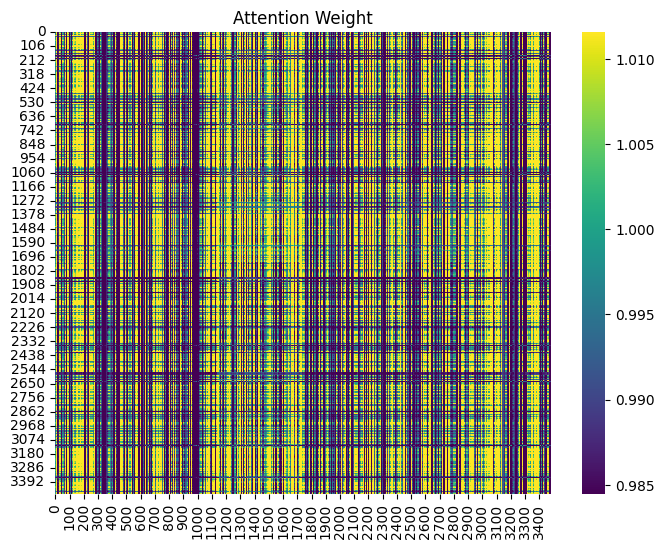

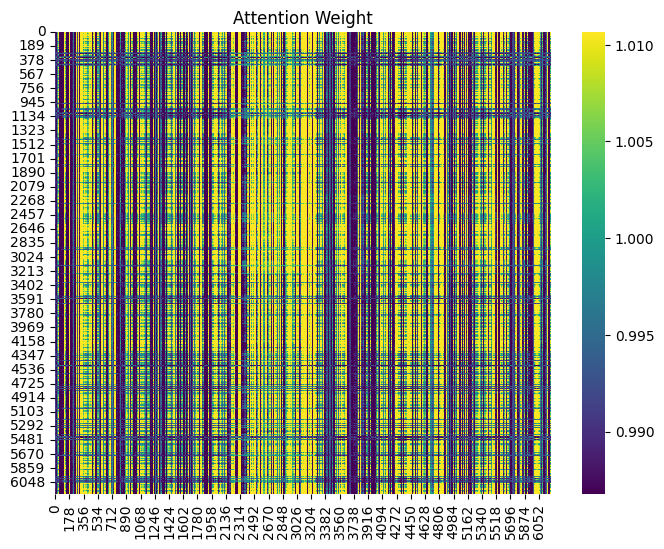

In [8]:
plot_attn_weight(attn, up_percentile=75, down_percentile=25)